In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Import Data
df=pd.read_csv('questions.csv')

# Check for null values
df[df.isnull().any(axis=1)]

# Drop rows with null Values
df.drop(df[df.isnull().any(axis=1)].index,inplace=True)

In [ ]:
df = df[0:40000]


In [ ]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
39995,39995,79669,79670,Why doesn't my Google Play app get downloads?,Why don't I get any downloads on my Android ap...,0
39996,39996,79671,79672,Is there life outside the earth?,How likely is it that life forms exist outside...,1
39997,39997,79673,79674,Why won't my Instagram suggestions (search his...,After clearing search history on insta my girl...,0
39998,39998,79675,79676,Does delivered go away when a message is read?,I have sent a message to a friend through mess...,0


In [ ]:
df.isnull().sum()


0    25109
1    14891
Name: is_duplicate, dtype: int64

In [ ]:
df.is_duplicate.value_counts()


0    25109
1    14891
Name: is_duplicate, dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
print("Not duplicate:")
print(df.question1[0])
print(df.question2[0])
print()
print("Not duplicate:")
print(df.question1[1])
print(df.question2[1])
print()
print("Is duplicate:")
print(df.question1[5])
print(df.question2[5])

Not duplicate:
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

Not duplicate:
What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

Is duplicate:
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


In [ ]:
def review_to_wordlist(review, remove_stopwords=True):
    # Clean the text, with the option to remove stopwords.
    
    # Convert words to lower case and split them
    words = review.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    review_text = " ".join(words)

    # Clean the text
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " 's ", review_text)
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    words = review_text.split()
    
    # Shorten words to their stems
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    
    review_text = " ".join(stemmed_words)
    
    # Return a list of words
    return(review_text)

In [ ]:
def process_questions(question_list, questions, question_list_name):
# function to transform questions and display progress
    for question in questions:
        question_list.append(review_to_wordlist(question))
        if len(question_list) % 10000 == 0:
            progress = len(question_list)/len(df) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [ ]:
questions1 = []     
process_questions(questions1, df.question1, "questions1")
print()
questions2 = []     
process_questions(questions2, df.question2, "questions2")

questions1 is 25.0% complete.
questions1 is 50.0% complete.
questions1 is 75.0% complete.
questions1 is 100.0% complete.

questions2 is 25.0% complete.
questions2 is 50.0% complete.
questions2 is 75.0% complete.
questions2 is 100.0% complete.


In [ ]:
questions1 

['step step guid invest share market india',
 'stori kohinoor ( koh i noor ) diamond',
 'increas speed internet connect use vpn',
 'mental lone solv it',
 'one dissolv water quik sugar salt methan carbon di oxid',
 'astrolog capricorn sun cap moon cap rise what say me',
 'buy tiago',
 'good geologist',
 'use instead',
 'motorola ( compani ) hack charter motorolla dcx3400',
 'method find separ slit use fresnel biprism',
 'read find youtub comment',
 'make physic easi learn',
 'first sexual experi like',
 'law chang status student visa green card us compar immigr law canada',
 'would trump presid mean current intern master s student f1 visa',
 'manipul mean',
 'girl want friend guy reject',
 'mani quora user post question readili answer googl',
 'best digit market institut banglor',
 'rocket look white',
 "what 's caus someon jealous",
 'question ask quora',
 'much 30 kv hp',
 'mean everi time look clock number same',
 'tip make job interview process medicin',
 'web applic',
 'societi pl

In [ ]:
# Take a look at some of the processed questions.
for i in range(5):
    print(questions1[i])
    print(questions2[i])
    print()

step step guid invest share market india
step step guid invest share market

stori kohinoor ( koh i noor ) diamond
would happen indian govern stole kohinoor ( koh i noor ) diamond back

increas speed internet connect use vpn
internet speed increas hack dns

mental lone solv it
find remaind math 23 24 math divid 24 23

one dissolv water quik sugar salt methan carbon di oxid
fish would surviv salt water



In [ ]:
# Stores the indices of unusable questions
invalid_questions = []
for i in range(len(questions1)):
    # questions need to contain a vowel (which should be part of a full word) to be valid
    if not re.search('[aeiouyAEIOUY]', questions1[i]) or not re.search('[aeiouyAEIOUY]', questions2[i]):
    # Need to subtract 'len(invalid_questions)' to adjust for the changing index values as questions are removed.
        invalid_questions.append(i-len(invalid_questions))
print(len(invalid_questions))

46


In [ ]:
invalid_questions

[812,
 1509,
 3303,
 3397,
 3658,
 3757,
 6870,
 7361,
 7812,
 9737,
 10098,
 10573,
 10602,
 11427,
 12799,
 13001,
 13781,
 15223,
 15478,
 17469,
 17495,
 18122,
 18521,
 19854,
 20051,
 20390,
 20494,
 20770,
 22213,
 23859,
 26770,
 28241,
 28949,
 31212,
 31725,
 31791,
 32671,
 32839,
 33188,
 33775,
 34722,
 35607,
 36274,
 36731,
 37155,
 38442]

In [ ]:
# Remove the invalid questions
for index in invalid_questions:
    df = df[df.id != index]
    questions1.pop(index)
    questions2.pop(index)

# These questions are also unusable, but were not detected initially.
# They were found when the function 'cosine_sim' stopped due to an error.
unexpected_invalid_questions = [36460]#,42273,65937,304867,306828,353918] 
for index in unexpected_invalid_questions:
    df = df[df.id != index]
    questions1.pop(index)
    questions2.pop(index)

In [ ]:
# Use TfidfVectorizer() to transform the questions into vectors,
# then compute their cosine similarity.
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [ ]:
Tfidf_scores = []
for i in range(len(questions1)):
    score = cosine_sim(questions1[i], questions2[i])
    Tfidf_scores.append(score)
    if i % 10000 == 0:
        progress = i/len(questions1) * 100
        print("Similarity Scores is {}% complete.".format(round(progress,2)))

ValueError: ignored

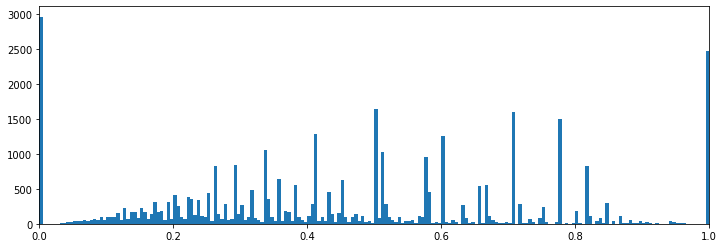

In [ ]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(Tfidf_scores, bins = 200)
plt.xlim(0,1)
plt.show()

In [ ]:
# Reset index to match the index values of questions1 and questions2
df = df.reset_index()
df

,level_0,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...,...,...
404343,404343,404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404344,404344,404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
404345,404345,404348,404348,789796,789797,What is one coin?,What's this coin?,0
404346,404346,404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
# Contains the processed questions for Doc2Vec
questions_labeled = []

for i in range(len(questions1)):
    # Question strings need to be separated into words
    # Each question needs a unique label
    questions_labeled.append(LabeledSentence(questions1[i].split(), df[df.index == i].qid1))
    questions_labeled.append(LabeledSentence(questions2[i].split(), df[df.index == i].qid2))
    if i % 10000 == 0:
        progress = i/len(questions1) * 100
        print("{}% complete".format(round(progress, 2)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/i

0.0% complete


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  

25.03% complete


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  

50.06% complete


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  

75.09% complete


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  

In [ ]:
questions_labeled

[LabeledSentence(words=['step', 'step', 'guid', 'invest', 'share', 'market', 'india'], tags=0    1
Name: qid1, dtype: int64),
 LabeledSentence(words=['step', 'step', 'guid', 'invest', 'share', 'market'], tags=0    2
Name: qid2, dtype: int64),
 LabeledSentence(words=['stori', 'kohinoor', '(', 'koh', 'i', 'noor', ')', 'diamond'], tags=1    3
Name: qid1, dtype: int64),
 LabeledSentence(words=['would', 'happen', 'indian', 'govern', 'stole', 'kohinoor', '(', 'koh', 'i', 'noor', ')', 'diamond', 'back'], tags=1    4
Name: qid2, dtype: int64),
 LabeledSentence(words=['increas', 'speed', 'internet', 'connect', 'use', 'vpn'], tags=2    5
Name: qid1, dtype: int64),
 LabeledSentence(words=['internet', 'speed', 'increas', 'hack', 'dns'], tags=2    6
Name: qid2, dtype: int64),
 LabeledSentence(words=['mental', 'lone', 'solv', 'it'], tags=3    7
Name: qid1, dtype: int64),
 LabeledSentence(words=['find', 'remaind', 'math', '23', '24', 'math', 'divid', '24', '23'], tags=3    8
Name: qid2, dtype: int64)

In [ ]:
# Split questions for computing similarity and determining the lengths of the questions.
questions1_split = []
for question in questions1:
    questions1_split.append(question.split())
    
questions2_split = []
for question in questions2:
    questions2_split.append(question.split())

In [ ]:
questions1_split 

[['step', 'step', 'guid', 'invest', 'share', 'market', 'india'],
 ['stori', 'kohinoor', '(', 'koh', 'i', 'noor', ')', 'diamond'],
 ['increas', 'speed', 'internet', 'connect', 'use', 'vpn'],
 ['mental', 'lone', 'solv', 'it'],
 ['one',
  'dissolv',
  'water',
  'quik',
  'sugar',
  'salt',
  'methan',
  'carbon',
  'di',
  'oxid'],
 ['astrolog',
  'capricorn',
  'sun',
  'cap',
  'moon',
  'cap',
  'rise',
  'what',
  'say',
  'me'],
 ['buy', 'tiago'],
 ['good', 'geologist'],
 ['use', 'instead'],
 ['motorola', '(', 'compani', ')', 'hack', 'charter', 'motorolla', 'dcx3400'],
 ['method', 'find', 'separ', 'slit', 'use', 'fresnel', 'biprism'],
 ['read', 'find', 'youtub', 'comment'],
 ['make', 'physic', 'easi', 'learn'],
 ['first', 'sexual', 'experi', 'like'],
 ['law',
  'chang',
  'status',
  'student',
  'visa',
  'green',
  'card',
  'us',
  'compar',
  'immigr',
  'law',
  'canada'],
 ['would',
  'trump',
  'presid',
  'mean',
  'current',
  'intern',
  'master',
  's',
  'student',
  'f1

In [ ]:
# Determine the length of questions to select more optimal parameters.
lengths = []
for i in range(len(questions1_split)):
    lengths.append(len(questions1_split[i]))
    lengths.append(len(questions2_split[i]))
lengths = pd.DataFrame(lengths, columns=["count"])

In [ ]:
lengths['count'].describe()


count    79906.000000
mean         5.870848
std          3.511479
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max        106.000000
Name: count, dtype: float64

In [ ]:
# 99% of the questions include 18 or fewer words.
np.percentile(lengths['count'], 99)

18.0

In [ ]:
# Build the model
model = Doc2Vec(dm = 1, min_count=1, window=10, size=150, sample=1e-4, negative=10)
model.build_vocab(questions_labeled)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
for epoch in range(5):
    model.train(questions_labeled,epochs=5,total_examples=model.corpus_count)
    print("Epoch #{} is complete.".format(epoch+1))

Epoch #1 is complete.
Epoch #2 is complete.
Epoch #3 is complete.
Epoch #4 is complete.
Epoch #5 is complete.


In [64]:
doc2vec_scores = []
for i in range(len(questions1_split)):
    # n_similarity computes the cosine similarity in Doc2Vec
    score = model.n_similarity(questions1_split[i],questions2_split[i])
    doc2vec_scores.append(score)
    if i % 10000 == 0:
        progress = i/len(questions1_split) * 100
        print("{}% complete.".format(round(progress,2)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  after removing the cwd from sys.path.


0.0% complete.
25.03% complete.
50.06% complete.
75.09% complete.


In [62]:
model.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('best', 0.6356614828109741),
 ('better', 0.46194738149642944),
 ('onlin', 0.38037657737731934),
 ('recommend', 0.37749752402305603),
 ('learn', 0.3542097210884094),
 ('noida', 0.35343149304389954),
 ('prefer', 0.3469616770744324),
 ('geophys', 0.3445093631744385),
 ('isbr', 0.34177708625793457),
 ('studi', 0.34136366844177246)]

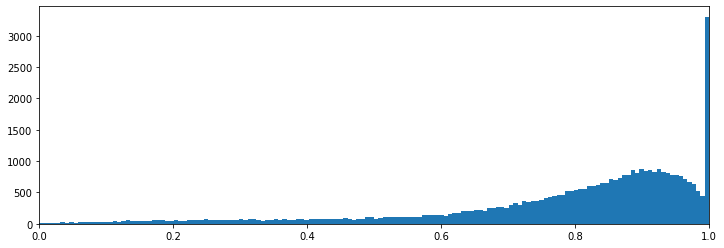

In [65]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(doc2vec_scores, bins = 200)
plt.xlim(0,1)
plt.show()